In [119]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
from src import get_genome_id
import os
from src.tools import MMSeqs
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}

# TODO: How does the model behave on short sequences versus long sequences? Is it picking up the spurious short ORFs?
# TODO: Find the pairwise distances between AntiFam sequences and model-predicted spurious sequences. 
# TODO: What fraction of each category are predicted spurious?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# for path in glob.glob('../data/ref/*_ref.csv'):
#     genome_id = get_genome_id(path)
#     prodigal_df = FASTAFile(f'../data/prodigal/{genome_id}_protein.faa').to_df(prodigal_output=True)
#     ref_df = pd.read_csv(path, index_col=0).loc[prodigal_df.index]
#     assert np.all(prodigal_df.index == ref_df.index), 'The indices in the FASTA file do not match the reference output.'
#     print((ref_df.query_seq == 'none').sum(), f'missing sequences in {path}')
#     ref_df['query_seq'] = prodigal_df['seq']
#     ref_df.to_csv(path)

In [52]:
def apply_threshold(results_df:pd.DataFrame, threshold:float=0.5, class_:int=0):
    results_df = results_df.copy()
    results_df['model_label'] = np.where(results_df[f'model_output_{class_}'] >= threshold, class_, int(not class_))
    return results_df 

In [114]:
model_name = 'campylobacterota_v3'

results_df = pd.read_csv('../data/results/prodigal_predict.csv', index_col=0)
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})
results_df = results_df.merge(pd.read_csv('../data/prodigal.csv', index_col=0), left_index=True, right_index=True)

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
results_df['gc_percent'] = results_df.genome_id.map(genome_metadata_df['gc_percent'])

In [35]:
antifam_df = pd.read_csv('../data/antifam.csv', index_col=0)

In [56]:
threshold = 0.5
df = pd.DataFrame(index=results_df.category.unique())
df['total'] = results_df.groupby('category').apply(len, include_groups=False)
df['num_predicted_spurious'] = apply_threshold(results_df, threshold=threshold).groupby('category').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
df['frac_predicted_spurious'] = df.num_predicted_spurious / df.total
df

,total,num_predicted_spurious,frac_predicted_spurious
match,399921,2736,0.006841
intergenic,4660,1687,0.362017
pseudogene,5347,338,0.063213
conflict,999,669,0.669670


In [62]:
results_df[(results_df.category == 'intergenic') & (results_df.model_label == 0) & (results_df.same_strand)][['sequence_identity', 'overlap_length']].sort_values('overlap_length')

,sequence_identity,overlap_length
36757,0.0,1
40540,0.0,1
35487,0.0,1
381418,0.0,1
389978,0.0,1
...,...,...
402953,0.0,47
378924,0.0,47
214115,0.0,49
212688,0.0,49


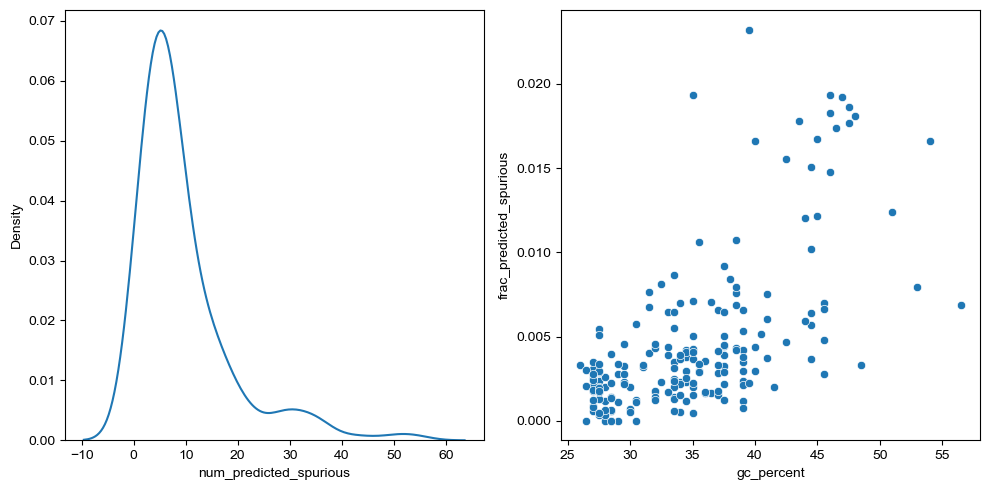

In [54]:
def figure_1(results_df, threshold:float=0.5):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    results_df = apply_threshold(results_df, threshold=threshold)
    
    ax_df = pd.DataFrame(index=results_df['genome_id'].unique())
    ax_df['gc_percent'] = results_df.groupby('genome_id').gc_percent.first()
    ax_df['num_predicted_spurious'] = results_df.groupby('genome_id').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['genome_size'] = results_df.groupby('genome_id').apply(len, include_groups=False)
    ax_df['frac_predicted_spurious'] = ax_df.num_predicted_spurious / ax_df.genome_size

    sns.kdeplot(data=ax_df, x='num_predicted_spurious', ax=ax_a)

    # sns.scatterplot(data=ax_df, x='gc_percent', y='num_predicted_spurious', ax=ax_b)
    sns.scatterplot(data=ax_df, x='gc_percent', y='frac_predicted_spurious', ax=ax_b)
    
    fig.tight_layout()
    plt.show()

figure_1(results_df, threshold=0.98)

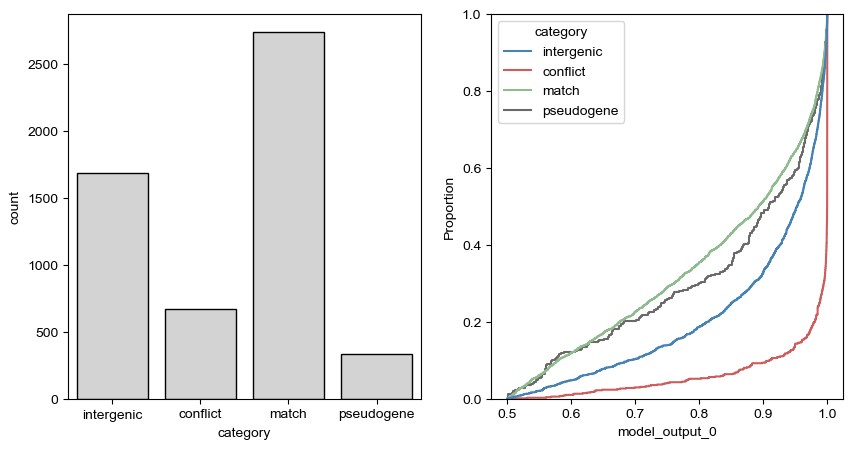

In [57]:
def figure_2(results_df, threshold:float=0.5):
    
    results_df = apply_threshold(results_df, threshold=threshold)
    results_df = results_df[results_df.model_label == 0].copy()

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))
    
    ax_a_df = pd.DataFrame(index=results_df.category.unique())
    ax_a_df['category'] = ax_a_df.index
    ax_a_df['count'] = results_df.value_counts('category')

    sns.barplot(data=ax_a_df, ax=ax_a, y='count', x='category', color='lightgray', edgecolor='black')

    ax_b_df = results_df[['model_output_0', 'category']].copy()

    palette = {'intergenic':'steelblue', 'conflict':'indianred', 'match':'darkseagreen', 'pseudogene':'dimgray'}
    sns.ecdfplot(data=ax_b_df, x='model_output_0', hue='category', palette=palette, ax=ax_b)

figure_2(results_df)


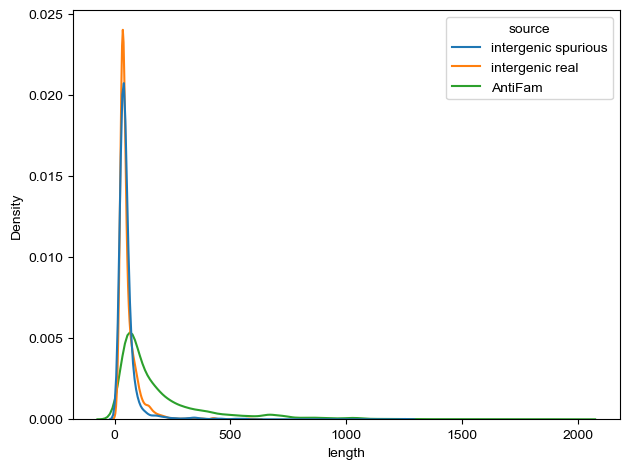

In [ ]:
# First curious about the intergenic sequences, many of which I suspect are actually spurious. 
# Some are probbaly actually conflicts, because of how lenient I was about the overlap length. 

# There seems to be no real correlation between overlap length and model output. 

# I was worried that the model would fail to catch some of the short, spurious ORFs that might
# not have any homology to known spurious translations. However, this does not seem to be the case. 

# What is making the model decide that some intergenic sequences are real and some are spurious?
# Do any of them bear any homology to known sequences? Could do an MMSeqs alignment against all the
# Campylobacterota sequences. 


# mmseqs = MMSeqs()
# query_df = results_df[results_df.category == 'intergenic'].copy().rename(columns={'query_seq':'seq'})
# subject_df = pd.read_csv('../data/dataset.csv', index_col=0)
# mmseqs.align(query_df=query_df, subject_df=subject_df, query_name='intergenic', subject_name='campylobacterota', sensitivity=10)


def figure_3(results_df:pd.DataFrame, antifam_df:pd.DataFrame, path:str=None):

    results_df = results_df[results_df.category == 'intergenic'].copy()
    antifam_df = antifam_df[antifam_df.seq.apply(len) < 2000].copy()

    fig, ax = plt.subplots()

    # ax_a_df = results_df[['model_output_0', 'overlap_length', 'top_hit_overlap_fraction', 'query_overlap_fraction', 'same_strand', 'top_hit_feature']].copy()
    # ax_a_df = ax_a_df[ax_a_df.overlap_length > 0].copy()
    # ax_a_df['top_hit_feature'] = ax_a_df.top_hit_feature.replace({'rRNA':'RNA', 'tRNA':'RNA', 'ncRNA':'RNA'})
    # hue_order = ['CDS', 'RNA', 'repeat_region', 'misc_feature', 'regulatory']
    # ax_a_df = ax_a_df.sort_values('top_hit_feature', key=np.vectorize(hue_order.index))
    # ax_a_df['overlap_length'] += np.random.uniform(low=-1, high=1, size=len(ax_a_df)) * 0.5

    # palette = {'CDS':'darkseagreen', 'RNA':'indianred', 'repeat_region':'steelblue', 'misc_feature':'dimgray', 'regulatory':'steelblue'}
    # sns.scatterplot(data=ax_a_df, x='overlap_length', y='model_output_0', hue='top_hit_feature', palette=palette)

    ax_a_df = pd.DataFrame(index=np.arange(len(results_df) + len(antifam_df)))
    ax_a_df['length'] = list(results_df.query_seq.apply(len)) + list(antifam_df.seq.apply(len))
    ax_a_df['source'] = list(np.where(results_df.model_label == 0, 'intergenic spurious', 'intergenic real')) + ['AntiFam'] * len(antifam_df)

    sns.kdeplot(data=ax_a_df, x='length', hue='source', common_norm=False, ax=ax)
    fig.tight_layout()
    plt.show()


figure_3(results_df, antifam_df)

    

In [102]:
results_df[(results_df.query_seq != 'none')]

,model_label,model_output_0,model_output_1,campylobacterota_v2_label,campylobacterota_v2_output_0,campylobacterota_v2_output_1,campylobacterota_v1_label,campylobacterota_v1_output_0,campylobacterota_v1_output_1,n_hits,...,top_hit_overlap_fraction,query_overlap_fraction,exact_match,in_frame,in_frame_c_terminus,in_frame_n_terminus,category,sequence_identity,genome_id,gc_percent
0,1,6.582465e-05,0.999934,1,0.000184,0.999815,1,0.000805,0.999195,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_025998455.1,38.5
1,1,5.040820e-07,1.000000,1,0.000002,0.999998,1,0.000022,0.999978,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_025998455.1,38.5
2,1,1.588158e-05,0.999984,1,0.000043,0.999957,1,0.000836,0.999164,2,...,1.0,1.0,True,True,True,True,match,1.0,GCF_025998455.1,38.5
3,1,4.013418e-06,0.999996,1,0.000015,0.999985,1,0.000141,0.999859,2,...,1.0,1.0,True,True,True,True,match,1.0,GCF_025998455.1,38.5
4,1,1.064454e-04,0.999894,1,0.000672,0.999328,1,0.005781,0.994219,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_025998455.1,38.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410921,0,6.725975e-01,0.327402,0,0.543788,0.456212,0,0.715443,0.284557,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_900197775.1,46.0
410922,1,1.586430e-02,0.984136,1,0.051618,0.948382,1,0.036759,0.963241,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_900197775.1,46.0
410923,1,5.630391e-03,0.994370,1,0.012424,0.987576,1,0.050393,0.949607,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_900197775.1,46.0
410924,1,3.253547e-05,0.999967,1,0.000204,0.999796,1,0.006100,0.993900,1,...,1.0,1.0,True,True,True,True,match,1.0,GCF_900197775.1,46.0


In [87]:
antifam_df.seq.apply(len).max()

9639

In [50]:
results_df[(results_df.category == 'intergenic') & (results_df.same_strand) & (results_df.top_hit_overlap_fraction > 0.1)][['top_hit_seq', 'query_seq']]

,top_hit_seq,query_seq
7227,MEEEKKEMKELKFDLELQKEVAKIGMSATLGATVVTSMFMKNKIAK...,MPILLPLATLITGILTVKTVNKTIKTYGRRKKRDERAKI
8365,MKSIYLFLLASLIGIEISIGVFLAPTIFYPAKFIGEGVLTHFQSGL...,MEFKKLDYNYLFIGENNEINIFIFTSKFNWD
16755,MKFDTKAYLEKLEHYARSYVDINDYILDDKNKDEIEQRILYVLNEA...,MLTLVELGKDDEFLHQTQHRPRLRNPKICMNFIKNLNIVSLC
22564,MNEISKIKKPKITLETKREIAKIGMSSTLLATAGTALFMKNKTAKT...,MPVLLAISAAGSLVLSLQTCSQAYKKIKNRRKYERNKQD
30871,MKEEKKDMKEIKFDLEVQKEVAKIGMTATLGATVVTSMFMKNSIAK...,MPILLPIATALTAILTVKTVKKSIKTYERRKKRYERDKI
...,...,...
389944,MLVKHKLERLLSDEETREDRNDFYVGYLKKSLADIESTHGGYWDLQ...,MEGIGICKLRAHHQSEGLSYQTLTKFYAL
393339,MHCILVHFWFALDIDNFPKYIQDITYSKDNKKLTENTINNILNLFK...,MQEKDFYQKEINTLFESSKNDDVLYLIYKIALNTGARLSSILNIQK...
398528,MNAVKELKKPKISLETKREIAKIGMSSSLLLTASTALFMKNKTAKA...,MPILITIGVIGSLVLSVQTNLRAYKKIKNRKRNERSKRA
400308,LKGAQVDLQEKRKAVSRFNKALKDLAKLEAEKKRIETKIENAKKII...,MSQISSINFKKSNPIQTQHNDRNLPPNYLIGGAVECNYNYKEALIL...
